

# Introdução
<p>
O presente trabalho tem como objetivo aplicar técnicas de estimação de modelos econométricos de séries temporais ministradas em sala de aula na disciplina de Econometria das Séries Temporais. Uma série fictícia, doravante Série19, será utilizada por todo o trabalho empírico que se propõe a identificar e modelar tendência, sazonalidade, ciclos, outliers, estacionariedade e efeitos ARCH presentes nessa série.
</p>

<p>
Além desta seção introdutória o trabalho é divido em 6 seções sendo 2 - Identificação da Série, onde serão identificadas propriedades da série, como sazonalidade, ciclos e estacionariedade; 3 - Estimação do modelo ARMA, seção responsável por modelar e escolher o melhor modelo de estimação da série; 4 - Modelo de previsão, nesta seção será apresentado o melhor o modelo preditivo para a Série19; 5 - Modelos ARCH, aqui será verificada a presença de efeitos ARCH a partir dos resíduos gerados pelo modelo escolhido na seção 3; e 6 - Conclusão.
</p>
<p>
O escopo deste artigo ficará definido modelar uma estimação para a série temporal Serie19 utilizando os modelos MA(p), AR(q) e ARCH(p). O software Jupyter e linguagem R foram escolhidos para auxiliar na identificação, modelagem e realização dos testes econométricos.
</p>




# Identificação da Série
## Inicializando bibliotecas

Para configurar o ambiente R foram utilizadas as bibliotecas tseries, forecast, ggplot2 e readr, conforme descrito abaixo:


In [1]:
# @hidden_cell
options(warn=-1)
rm(list=ls())

library("tseries")
library(forecast)
library(ggplot2)
library(readr)
library(lmtest)

theme_set(theme_minimal())

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


Loading required package: zoo



Attaching package: ‘zoo’



The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Carregando dados

O arquivo series.csv contém diversas séries disponibilizadas para análise econométrica, neste trabalho utilizaremos apenas a Série19 contida neste arquivo.


In [2]:
################################################################################
## LOAD SERIES                                                                ##
################################################################################

series <- read_csv("series.csv",col_types = cols())

serie <- series$SER19
nobs <- length(serie)
nyears <- floor(nobs/12)
nmonths <- nobs -  nyears*12

endYear <- 2018
endMonth <- 12

## transforma série em timeseries do R - para 90 obs 7,5 anos
#tserie <- ts(serie, start=c(endYear - nyears, endMonth - nmonths+1), end=c(endYear, endMonth), frequency=12)
tserie <- ts(serie,  frequency=1)


## Resumo da Série


A série é formada por 90 observações e quando plotada na imagem abaixo sugere a média próxima de zero, variância estável (homocedasticidade) e estacionariedade na Série19. Na primeira metade da série podemos identificar visualmente uma possível sazonalidade (linhas verticais pontilhadas).


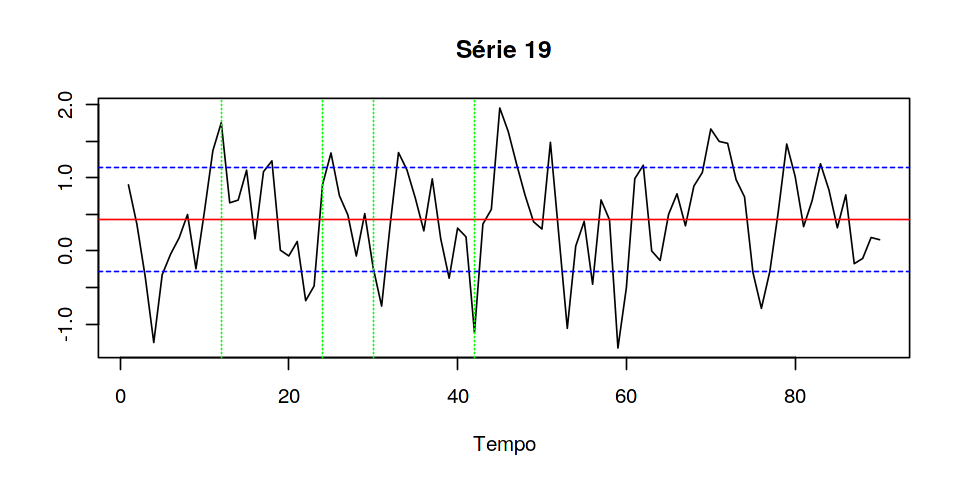

In [3]:
#tserie <- ts(serie, frequency=1)
s <- summary(tserie)
u <-mean(serie)
sd <- sd(serie)

options(repr.plot.width=8, repr.plot.height=4)

ts.plot(tserie, xlab="Tempo", ylab="", main="Série 19")
abline(h = u, col="red", lwd=1, lty=1)
abline(h = u+sd, col="blue", lwd=1, lty=2)
abline(h = u-sd, col="blue", lwd=1, lty=2)

abline(v=12,col="green", lwd=1, lty=3)
abline(v=24,col="green", lwd=1, lty=3)
abline(v=30,col="green", lwd=1, lty=3)
abline(v=42,col="green", lwd=1, lty=3)

In [4]:
print(s)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.32719 -0.03223  0.41430  0.43356  0.95765  1.95369 




## Estacionariedade

Para verificação da estacionariedade, foram utilizados os testes Augmented Dickey-Fuller e KPSS que rejeitaram a 1% a hipótese nula de não estacionariedade.


In [5]:
################################################################################
## TESTE ESTACIONARIEDADE                                                     ##
################################################################################

adf.test(tserie)
kpss.test(tserie)



	Augmented Dickey-Fuller Test

data:  tserie
Dickey-Fuller = -4.6242, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  tserie
KPSS Level = 0.068504, Truncation lag parameter = 3, p-value = 0.1




# Estimação do modelo ARMA
## Análise

A Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF) nos ajuda identificar as possíveis variações $AR(p)$ e $MA(q)$ em um processo $ARMA(p, q)$. Onde a ordem diferente de zero em ACF indica a ordem do processo MA e de forma análoga a ordem de PACF indica a ordem do processo AR.


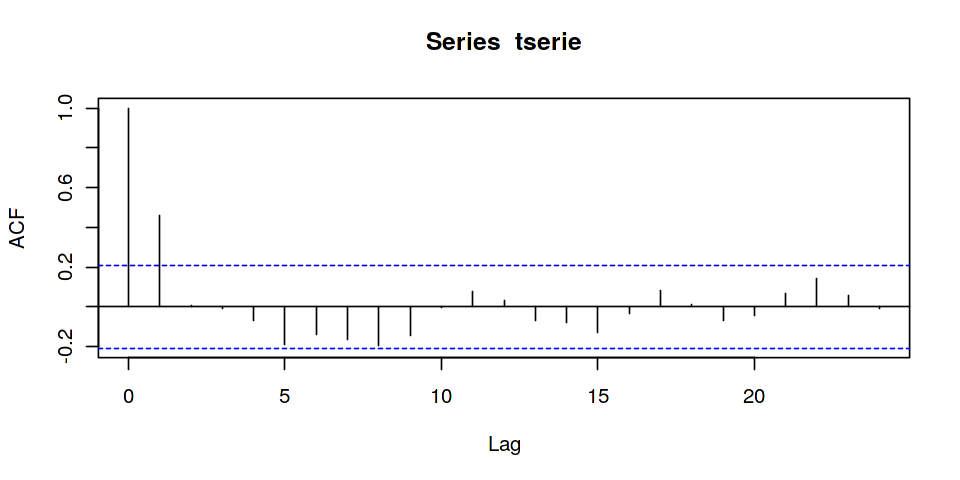

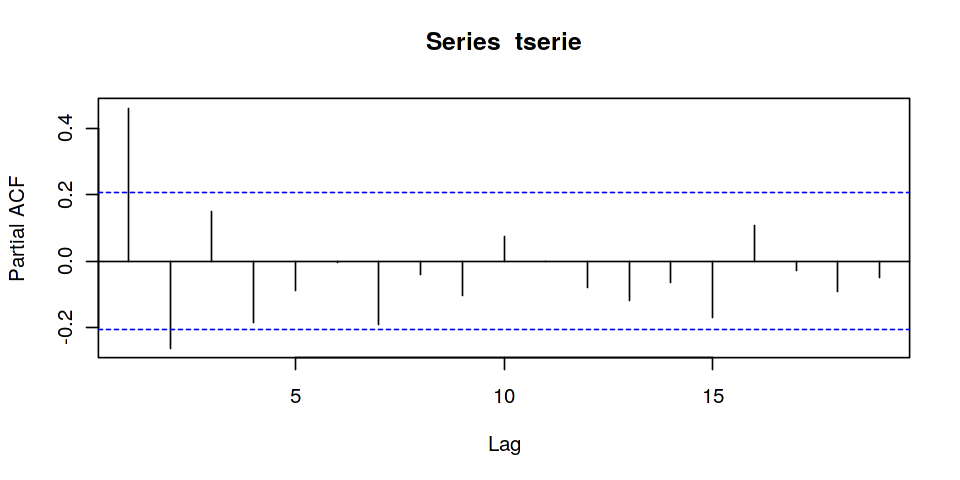

In [6]:

################################################################################
## FUNCOES AUTO CORRELACAO                                                    ##
################################################################################

tserie.acf <- acf(tserie,lag.max=24)
tserie.pacf <- pacf(tserie)


Como a autocorrelação em zero sempre será um, no correlograma de ACF identificamos um possível processo $MA(1)$ e pelo PACF temos um indicativo de $AR(2)$ na Série19.

## Gerando possíveis modelos

O código abaixo gera todos os modelos $ARMA(p, q)$, onde $p$ varia entre 0 e 2 e $q$ entre 0 e 1. Para cada estimação faremos o cálculo de ajustamento do modelo pelos métodos AIC e BIC, o cálculo do R² e a verificação da significância dos parâmetros.


In [7]:

################################################################################
## ARMA - AR(1,2) && MA(1)                                                    ##
################################################################################

for (p in c(0,1,2)){
  for (q in c(0,1)){ 
    ARMAN <- arima(tserie, order = c(p,0,q))

    cat(sprintf("Verificando ARIMA(%i, 0, %i) ", p, q))     
    cat(sprintf("AIC: %f\t",AIC(ARMAN)))
    cat(sprintf("BIC: %f\n",BIC(ARMAN)))
    
    cat(sprintf('p-value:\n'))
    print(
      (1-pnorm(abs(ARMAN$coef)/sqrt(diag(ARMAN$var.coef))))*2)

    cat(sprintf('R^2 = %f\n\n', cor(fitted(ARMAN),serie)^2))
      
      
    cat(sprintf('--------------------------------\n'))
    
  }
}

Verificando ARIMA(0, 0, 0) AIC: 196.634755	BIC: 201.634374
p-value:
   intercept 
5.561153e-09 
R^2 = 0.039422

--------------------------------
Verificando ARIMA(0, 0, 1) AIC: 168.539470	BIC: 176.038899
p-value:
         ma1    intercept 
4.440892e-16 1.183029e-05 
R^2 = 0.289177

--------------------------------
Verificando ARIMA(1, 0, 0) AIC: 177.235404	BIC: 184.734833
p-value:
         ar1    intercept 
8.015971e-07 3.108678e-04 
R^2 = 0.213716

--------------------------------
Verificando ARIMA(1, 0, 1) AIC: 170.213320	BIC: 180.212559
p-value:
         ar1          ma1    intercept 
5.648516e-01 2.150096e-06 3.615757e-05 
R^2 = 0.290436

--------------------------------
Verificando ARIMA(2, 0, 0) AIC: 172.853765	BIC: 182.853004
p-value:
         ar1          ar2    intercept 
1.078178e-08 9.993760e-03 3.138832e-06 
R^2 = 0.268688

--------------------------------
Verificando ARIMA(2, 0, 1) AIC: 171.936315	BIC: 184.435363
p-value:
         ar1          ar2          ma1    intercept

Dos modelos testados acima, encontramos o $ARMA(0, 1)$ como o modelo com menor AIC e BIC e simultaneamente com todos os parâmetros significantes  ($ma_1$). Os modelos $ARMA(2, 1)$ e $ARMA(1, 1)$ tiveram um R² maior, porém apenas o parâmetro do $MA(1)$ foi significante em ambos, o que sugere a confirmação do modelo $MA(1)$ como o melhor modelo.

## Melhor Modelo

Como visto na seção anterior, o melhor modelo escolhido a partir da análise do correlograma identificamos o $MA(1)$ como melhor candidato. Abaixo temos a imagem da série $MA(1)$ estimada ajustada aos dados da Série19.


z test of coefficients:

          Estimate Std. Error z value  Pr(>|z|)    
ma1       0.591606   0.072586  8.1505 3.625e-16 ***
intercept 0.435886   0.099502  4.3807 1.183e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


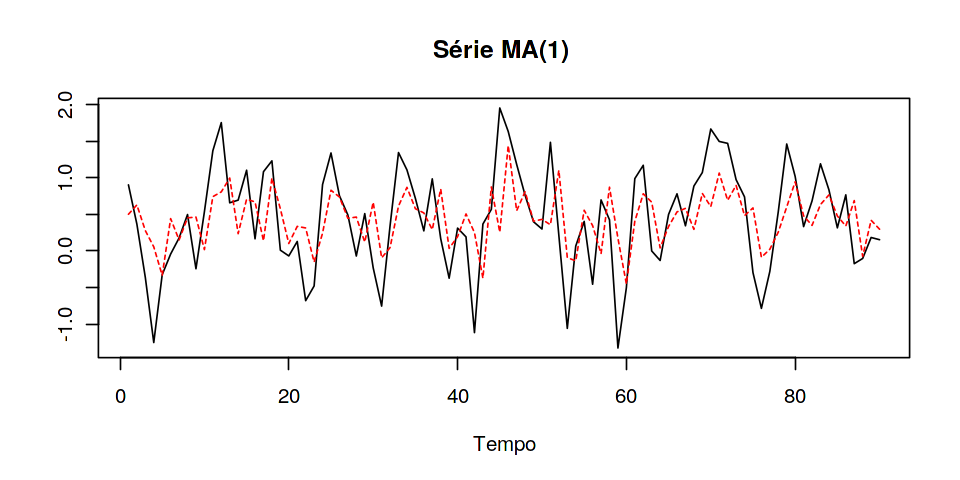

In [8]:
################################################################################
## MELHOR MODELO ARIMA(0,0,1) ou MA(1)                                        ##
################################################################################

ARMA <- arima(tserie, order = c(0,0,1))
ARMA_fit <- tserie - residuals(ARMA)

ts.plot(tserie, xlab="Tempo", ylab="", main="Série MA(1) ")
points(ARMA_fit, type = "l", col = 2, lty = 2)


coeftest(ARMA)

Apesar do modelo $ARMA(0, 1)$ ter sido o melhor dentre os testados, a análise dos resíduos ainda indica uma autocorrelação não especificada no modelo. Em ACF e PACF temos em $t-5$ um grau de correlação significante.

In [9]:
acf(residuals(ARMA))
pacf(residuals(ARMA))


## Modelo alternativo

Como dito na seção 2.3, há indícios de sazonalidade em boa parte da série, sendo assim foi gerado um modelo $ARMA(0,0,6)$ para tentar capturar esses efeitos.


In [10]:
################################################################################
## MELHOR MODELO ARIMA(0,0,6) ou MA(6)                                        ##
################################################################################

MA_6 <- arima(tserie, order = c(0,0,6))
MA_6_fit <- tserie - residuals(MA_6)

cat(sprintf("Verificando ARIMA(0, 0, 6) "))     
cat(sprintf("AIC: %f\t",AIC(MA_6)))
cat(sprintf("BIC: %f\n",BIC(MA_6)))

cat(sprintf('p-value:\n'))
print(
  (1-pnorm(abs(MA_6$coef)/sqrt(diag(MA_6$var.coef))))*2)

cat(sprintf('R^2 = %f\n\n', cor(fitted(MA_6),serie)^2))
      
      
cat(sprintf('--------------------------------\n'))

coeftest(MA_6)


Verificando ARIMA(0, 0, 6) 

AIC: 170.615726	

BIC: 190.614203


p-value:


         ma1          ma2          ma3          ma4          ma5          ma6 
1.285632e-06 1.682366e-01 1.661398e-02 1.540931e-02 2.824818e-06 1.293764e-02 
   intercept 
0.000000e+00 


R^2 = 0.381501



--------------------------------



z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ma1        0.556986   0.115033  4.8420 1.286e-06 ***
ma2       -0.187493   0.136072 -1.3779   0.16824    
ma3       -0.306044   0.127777 -2.3951   0.01661 *  
ma4       -0.298277   0.123122 -2.4226   0.01541 *  
ma5       -0.510477   0.109003 -4.6832 2.825e-06 ***
ma6       -0.254677   0.102466 -2.4855   0.01294 *  
intercept  0.448193   0.012595 35.5860 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Analisando a significância dos parâmetros vemos que a 1% além de $ma_1$ o parâmetro $ma_5$ também será significante, nota-se também que os parâmetros $ma_4$ e $ma_6$ ficam muito próximo da significância a 1%. Outro fator positivo é que o R² neste modelo é melhor que o modelo $MA(1)$.

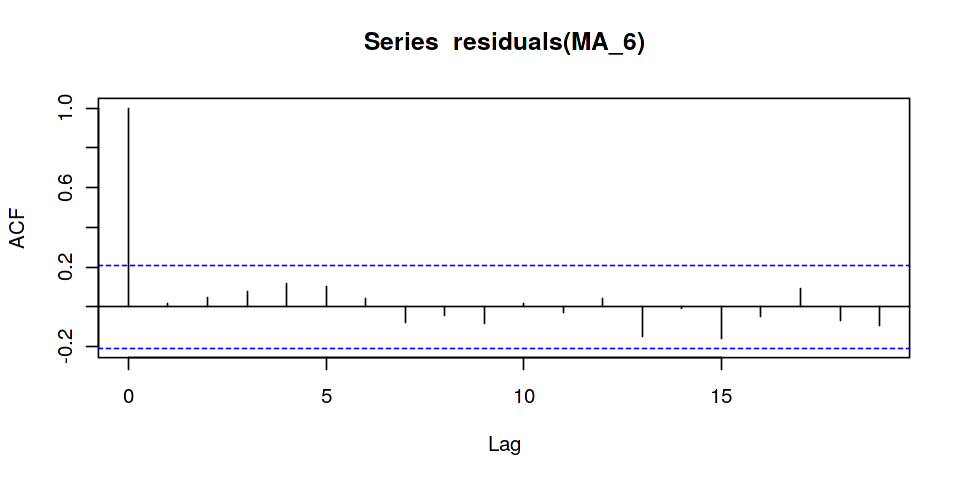

In [11]:
ts.plot(tserie, xlab="Tempo", ylab="", main="Série MA(6) ")
points(MA_6_fit, type = "l", col = 2, lty = 2)

     
acf(residuals(MA_6))
pacf(residuals(MA_6))

Além da significância dos parâmetros também podemos verificar o melhor comportamento dos correlogramas dos resíduos em $MA(6)$ estimado quando comparado ao $MA(1)$

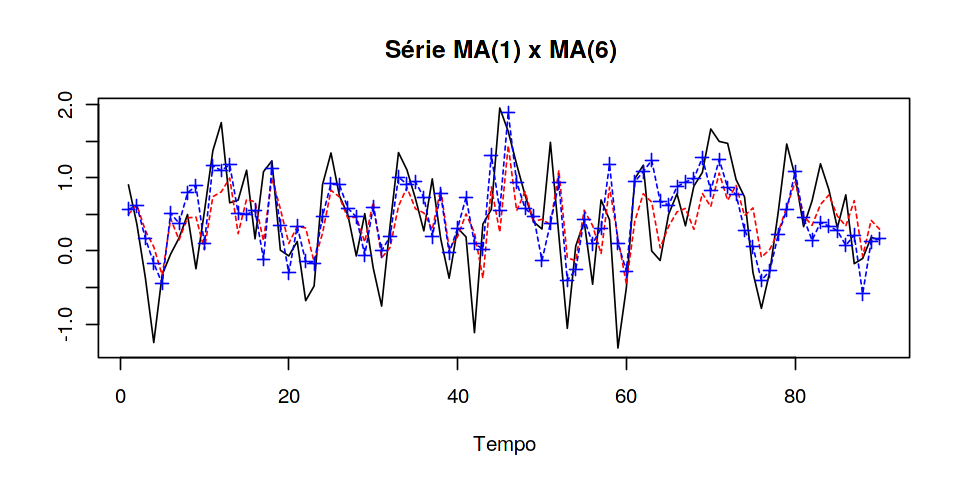

In [12]:
################################################################################
## MA(6) x MA(1)                                                              ##
################################################################################
ts.plot(tserie, xlab="Tempo", ylab="", main="Série MA(1) x MA(6) ")
points(ARMA_fit,  type="l",col = 2 ,lty=2)
points(MA_6_fit, type = "o", pch=3, col =4, lty = 2)

Comparando os ajustamentos de MA(1), representado pela linha pontilhada vermelha, e MA(6), representado pela linha pontilhada azul com uma cruz, no gráfico acima também verificamos que em MA(6) há uma melhor aderência aos dados da Série19.


# Modelo de previsão

Para definir um melhor modelo de previsão utilizaremos a técnica de cross-validation, onde a Série19 será divida em um subconjunto de treinamento e outro de teste. O conjunto de treinamento será composto pelos primeiros 60 valores da série e o de teste com os 30 valores restantes.

In [13]:
tserie.training <- subset(tserie, end=60) 
tserie.test <- subset(tserie, start=61) 



Após essa divisão dos conjuntos, aplicamos as possíveis combinações de MA(1) e AR(2) como feito no modelo da seção 3 e depois avaliamos qual modelo melhor se ajusta ao conjunto de teste.

In [14]:
for (p in c(0,1,2)){
  for (q in c(0,1)){ 
    cat(sprintf("Verificando ARIMA(%i, 0, %i)\n\n ", p, q))    
    tserie.trainingModel <- arima(tserie.training, order = c(p,0,q))
    tserie.testModel <- Arima(tserie.test, model=tserie.trainingModel)
    print(accuracy(tserie.testModel))
    
    cat(sprintf('--------------------------------\n'))
    
  }
}

Verificando ARIMA(0, 0, 0)

                   ME      RMSE       MAE      MPE    MAPE     MASE      ACF1
Training set 0.23935 0.6540613 0.5517686 4295.655 4311.99 1.185798 0.5880841
--------------------------------
Verificando ARIMA(0, 0, 1)

                     ME      RMSE       MAE      MPE     MAPE      MASE
Training set 0.1472669 0.5034271 0.4149128 7621.289 7640.343 0.8916833
                  ACF1
Training set 0.2475503
--------------------------------
Verificando ARIMA(1, 0, 0)

                     ME      RMSE       MAE     MPE     MAPE     MASE      ACF1
Training set 0.1356623 0.5205702 0.4448817 8348.66 8368.877 0.956089 0.3395349
--------------------------------
Verificando ARIMA(1, 0, 1)

                    ME      RMSE       MAE     MPE     MAPE      MASE      ACF1
Training set 0.148214 0.5043988 0.4160212 7575.79 7594.799 0.8940652 0.2510058
--------------------------------
Verificando ARIMA(2, 0, 0)

                     ME      RMSE      MAE      MPE     MAPE      

Utilizando o Erro quadrático médio (RMSE) como métrica para escolher o melhor modelo preditivo, escolhemos o $MA(1)$ com o valor $RMSE = 0.5034271$. O gráfico abaixo ilustra como seria o ajuste do modelo MA(1) aos dados de teste.

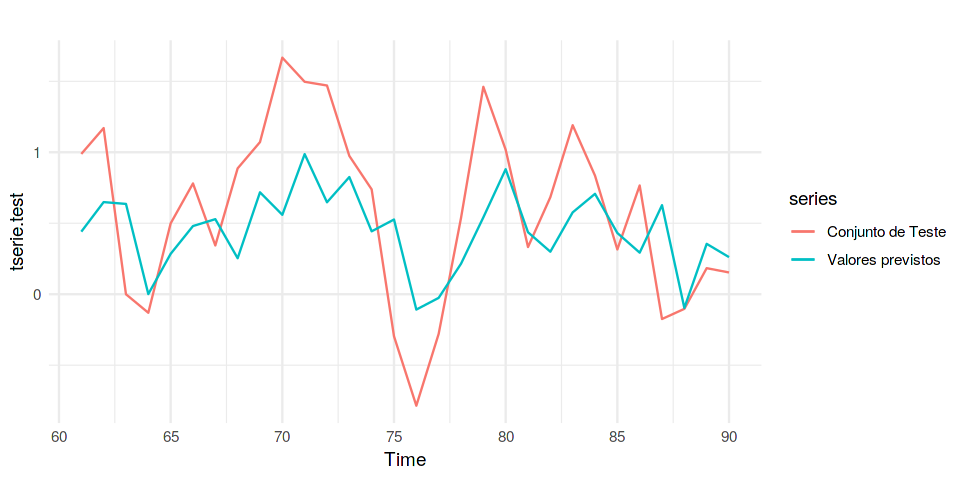

In [15]:
tserie.trainingModel <- Arima(tserie.training, order=c(0,0,1))
tserie.testModel <- Arima(tserie.test, model=tserie.trainingModel)
autoplot(tserie.test, series="Conjunto de Teste") +
  autolayer(fitted(tserie.testModel, h=1),
            series="Valores previstos")

# GARCH

## Resíduos

Antes de modelar o efeito GARCH na Série19, vamos analisar se os resíduos do modelo $ARMA(0,6)$ são autocorrelacionados, em caso positivo haverá efeito GARCH. De forma análoga como foi feito para identificar AR e MA na Série19, para identificar autocorrelação dos resíduos utilizaremos os correlogramas ACF e PACF.

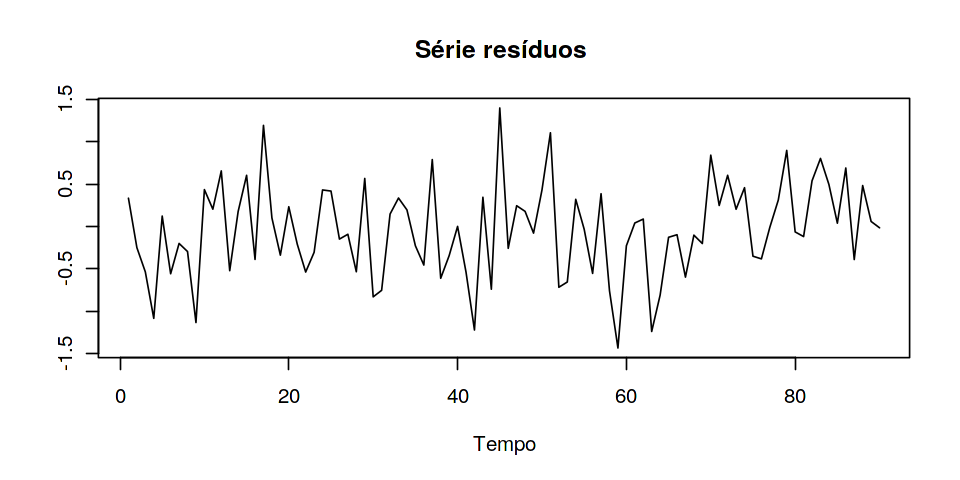

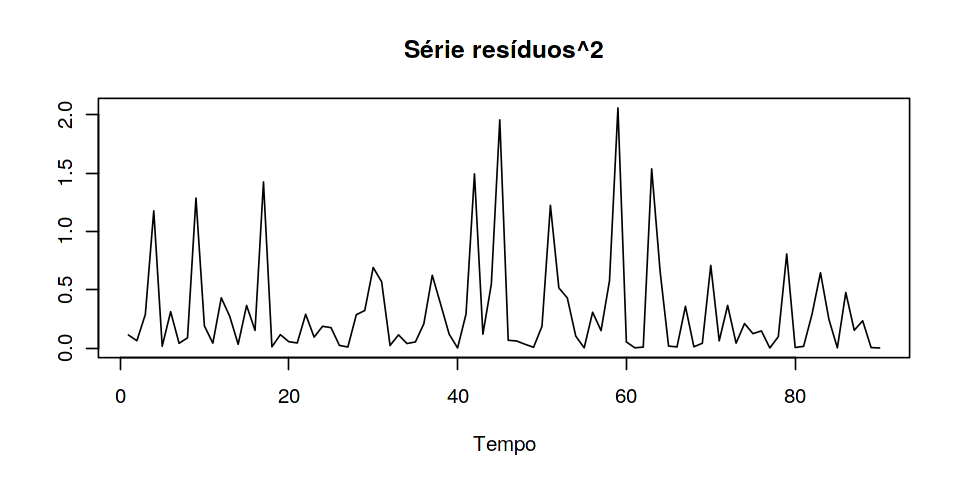

In [16]:
################################################################################
## RESIDUOS DE MA(6)                                                          ##
################################################################################


ts.plot(residuals(MA_6), xlab="Tempo", ylab="", main="Série resíduos ")
ts.plot(residuals(MA_6)^2, xlab="Tempo", ylab="", main="Série resíduos^2")


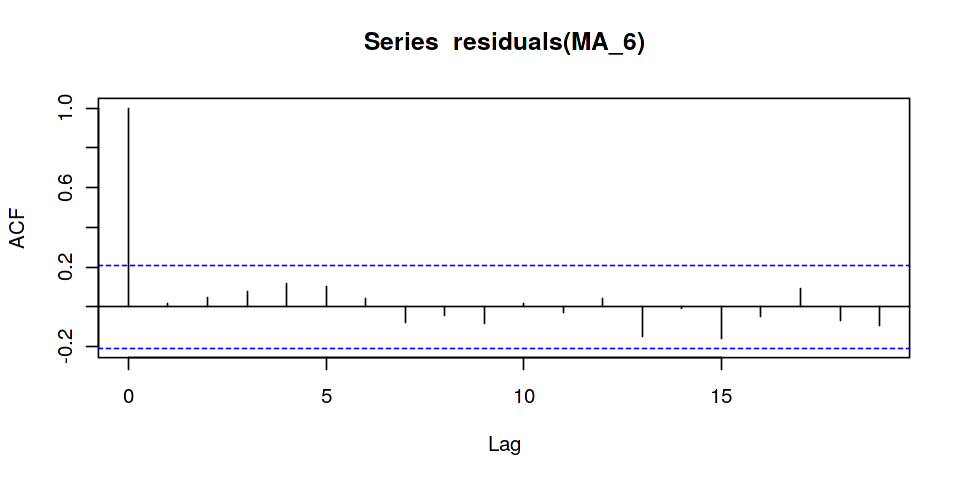

In [17]:

acf(residuals(MA_6))  ##NAO HA EFEITO ARCH
acf(residuals(MA_6)^2)  ##NAO HA EFEITO ARCH
pacf(residuals(MA_6))  ##NAO HA EFEITO ARCH



Além da inexistência de autocorrelação dos resíduos, podemos também testar se os resíduos seguem uma distribuição normal de média zero por meio do teste shapiro, que não rejeita a hipótese de que os resíduos seguem uma distribuição normal:


In [18]:
shapiro.test(residuals(MA_6))
mean(residuals(MA_6))


	Shapiro-Wilk normality test

data:  residuals(MA_6)
W = 0.99586, p-value = 0.9948


[1] -0.04361599

Hipótese de normalidade dos resíduos também confirmada pelos gráficos abaixo:

In [19]:
checkresiduals(MA_6)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,6) with non-zero mean
Q* = 4.8522, df = 3, p-value = 0.1829

Model df: 7.   Total lags used: 10



## Modelando GARCH(1,1)

A título de demonstração de como modelar um efeito GARCH, temos abaixo um exemplo de como seria modelado um efeito $GARCH(1,1)$ para a Série19

In [20]:

tserie.garch <- garch(tserie, c(1,1))
summary(tserie.garch) 



 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     4.530838e-01     1.000e+00
     2     5.000000e-02     1.000e+00
     3     5.000000e-02     1.000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1  2.847e+01
     1    4  2.629e+01  7.65e-02  2.60e-01  1.2e-01  2.8e+02  1.6e-01  3.69e+01
     2    6  2.616e+01  4.77e-03  4.51e-03  1.1e-02  3.6e+00  1.6e-02  5.44e-01
     3    7  2.604e+01  4.87e-03  5.14e-03  2.4e-02  2.4e+00  3.2e-02  1.16e-01
     4    8  2.593e+01  4.13e-03  6.56e-03  5.4e-02  1.9e+01  6.5e-02  1.03e-01
     5   10  2.592e+01  2.84e-04  2.86e-04  4.7e-03  1.9e+01  6.5e-03  2.82e-02
     6   12  2.591e+01  5.55e-04  5.54e-04  1.1e-02  1.1e+01  1.3e-02  2.84e-02
     7   14  2.590e+01  1.10e-04  1.09e-04  2.2e-03  2.0e+02  2.6e-03  1.98e-02
     8   16  2.590e+01  2.17e-04  2.17e-04  4.4e-03  2.8e+01  5.2e-03  1.78e-02
     9   18  2.589e+01  4.29e-04  4.28e-04  8.9e-03 


Call:
garch(x = tserie, order = c(1, 1))

Model:
GARCH(1,1)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.78233 -0.05853  0.53716  1.10562  2.54739 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)
a0 5.115e-01   5.713e-01    0.895    0.371
a1 2.376e-01   2.550e-01    0.932    0.352
b1 1.163e-14   9.416e-01    0.000    1.000

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 2.3722, df = 2, p-value = 0.3054


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.055428, df = 1, p-value = 0.8139


Como esperado, nenhum dos coeficientes do modelo estimado possui significância estatística a 1%.

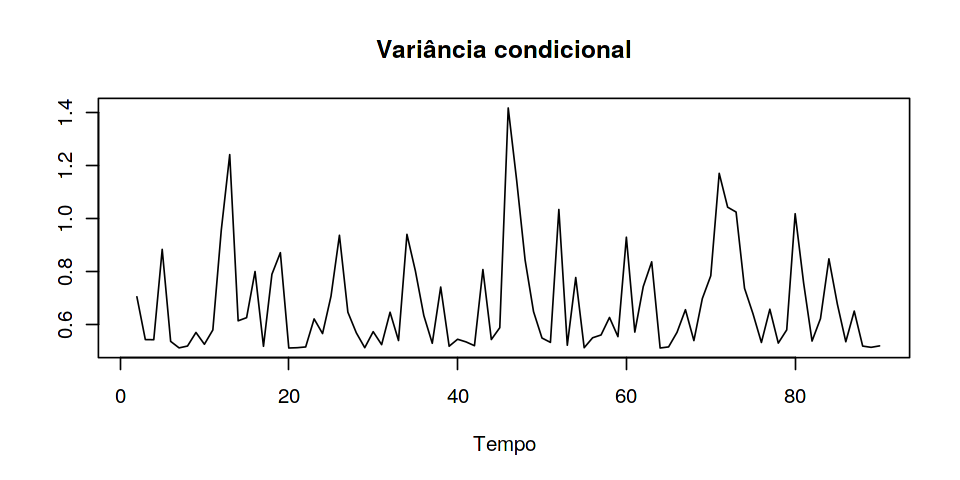

In [21]:

ht.arch08=tserie.garch$fit[,1]^2
plot(ht.arch08,xlab="Tempo", ylab="", main='Variância condicional')


# Conclusão

Após estimados modelos ARMA para ajustes dos dados, ARMA para previsão e modelos GARCH, nota-se que dentro dos possíveis modelos indicados pelos correlogramas o modelo $MA(1)$ foi o mais indicado para o ajuste dos dados à Série19 e também para previsão de valores futuros, conclui-se também que não há efeito GARCH na série, isto é, não possui variância condicional nos termos de erro. Também foi identificado um modelo alternativo ao $MA(1)$, o $MA(6)$ que se ajusta melhor à Série19 e elimina todas as autocorrelações dos resíduos.
